In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


2024-02-19 10:39:41.219848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 10:39:41.219960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 10:39:41.346846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


# Table of Contents

* [Load the Disaster Tweets](#h0)

* [Explore the dataset](#h1)

* [Preprocess the data](#h2)

* [Loadmodel](#h3)

* [Train your model](#h4)

* [Generate the submission file](#h5)

# Load the Disaster Tweets <a class="anchor"  id="h0"></a>

In [3]:
test=pd.read_csv('/kaggle/input/kaggledisastertweet/test.csv')
train=pd.read_csv('/kaggle/input/kaggledisastertweet/train.csv')

# Explore the dataset <a class="anchor"  id="h1"></a>


## Remove Missing Values

In [4]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
missing_values = train.isnull().sum()

In [6]:
missing_values

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
train = train.drop('location', axis=1)
test = test.drop('location', axis=1)

In [8]:
train

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,Police investigating after an e-bike collided ...,1


In [9]:
test

,id,keyword,text
0,0,NaN,Just happened a terrible car crash
1,2,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
3258,10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [10]:
test=test.dropna()
train=train.dropna()

In [11]:
test

,id,keyword,text
15,46,ablaze,Birmingham Wholesale Market is ablaze BBC News...
16,47,ablaze,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,58,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,60,ablaze,PSA: IÛªm splitting my personalities.\n\n?? t...
...,...,...,...
3247,10806,wrecked,RT CNBC '3 words from Disney CEO Bob Iger wrec...
3248,10807,wrecked,Smackdown tyme this should put me in a good mo...
3249,10816,wrecked,@thrillhho jsyk I haven't stopped thinking abt...
3250,10820,wrecked,@stighefootball Begovic has been garbage. He g...


In [12]:
train

,id,keyword,text,target
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,Crying out for more! Set me ablaze,0
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...
7578,10830,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,Three days off from work and they've pretty mu...,0
7580,10832,wrecked,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,@engineshed Great atmosphere at the British Li...,0


## Setting Index

In [13]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

In [14]:
train


,keyword,text,target
id,,,
48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
49,ablaze,We always try to bring the heavy. #metal #RT h...,0
50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
52,ablaze,Crying out for more! Set me ablaze,0
53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...
10830,wrecked,@jt_ruff23 @cameronhacker and I wrecked you both,0
10831,wrecked,Three days off from work and they've pretty mu...,0
10832,wrecked,#FX #forex #trading Cramer: Iger's 3 words tha...,0


## Concat

In [15]:
df = pd.DataFrame()

In [16]:
df['text']=train["keyword"]+"[SEP]"+train["text"]

In [17]:
df['target']=train['target']

In [18]:
df

,text,target
id,,
48,ablaze[SEP]@bbcmtd Wholesale Markets ablaze ht...,1
49,ablaze[SEP]We always try to bring the heavy. #...,0
50,ablaze[SEP]#AFRICANBAZE: Breaking news:Nigeria...,1
52,ablaze[SEP]Crying out for more! Set me ablaze,0
53,ablaze[SEP]On plus side LOOK AT THE SKY LAST N...,0
...,...,...
10830,wrecked[SEP]@jt_ruff23 @cameronhacker and I wr...,0
10831,wrecked[SEP]Three days off from work and they'...,0
10832,wrecked[SEP]#FX #forex #trading Cramer: Iger's...,0


# Preprocess the data <a class="anchor"  id="h2"></a>

In [19]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test["text"]

In [20]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 10
AUTO = tf.data.experimental.AUTOTUNE

# Loadmodel <a class="anchor"  id="h3"></a>

In [21]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_en_uncased/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_nlp/src/models/backbone.py:37: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem (SlicingOpLambda)    │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ classifier_dropout (Dropout)                  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train your model <a class="anchor"  id="h4"></a>

In [22]:
# Compile
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=["accuracy"]
)


# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/10


I0000 00:00:1708339226.470438      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


189/189 [==============================] - 93s 368ms/step - loss: 0.6937 - accuracy: 0.5655 - val_loss: 0.6827 - val_accuracy: 0.5784
Epoch 2/10
189/189 [==============================] - 65s 342ms/step - loss: 0.6854 - accuracy: 0.5709 - val_loss: 0.6827 - val_accuracy: 0.5784
Epoch 3/10
189/189 [==============================] - 65s 342ms/step - loss: 0.6852 - accuracy: 0.5709 - val_loss: 0.6821 - val_accuracy: 0.5784
Epoch 4/10
189/189 [==============================] - 65s 342ms/step - loss: 0.6870 - accuracy: 0.5680 - val_loss: 0.6810 - val_accuracy: 0.5784
Epoch 5/10
189/189 [==============================] - 64s 341ms/step - loss: 0.6849 - accuracy: 0.5684 - val_loss: 0.6819 - val_accuracy: 0.5784
Epoch 6/10
189/189 [==============================] - 64s 341ms/step - loss: 0.6841 - accuracy: 0.5709 - val_loss: 0.6810 - val_accuracy: 0.5784
Epoch 7/10
189/189 [==============================] - 64s 341ms/step - loss: 0.6839 - accuracy: 0.5709 - val_loss: 0.6829 - val_accuracy: 0.5

## Results

## Results

In [23]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Assuming you have trained your classifier and obtained predictions on validation data

# Get predictions on validation data
y_pred = classifier.predict(X_val)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_labels)

# Generate classification report
report = classification_report(y_val, y_pred_labels)

# Calculate F1 score
f1 = f1_score(y_val, y_pred_labels, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)


48/48 [==============================] - 8s 137ms/step
Accuracy: 0.5784248841826605
F1 Score: 0.42393572224372766
Classification Report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73       874
           1       0.00      0.00      0.00       637

    accuracy                           0.58      1511
   macro avg       0.29      0.50      0.37      1511
weighted avg       0.33      0.58      0.42      1511



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

In [24]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

189/189 [==============================] - 26s 137ms/step


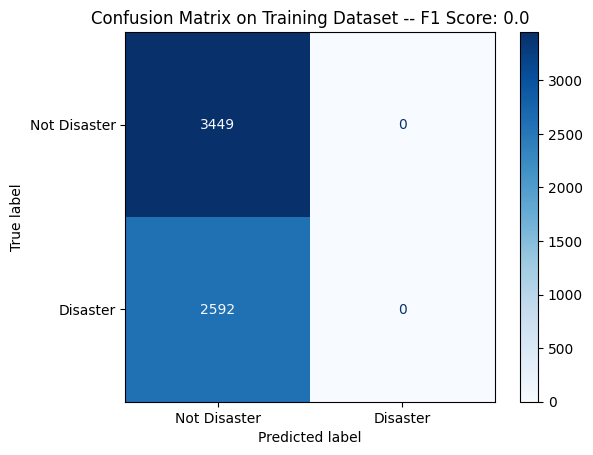

In [25]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 [==============================] - 7s 136ms/step


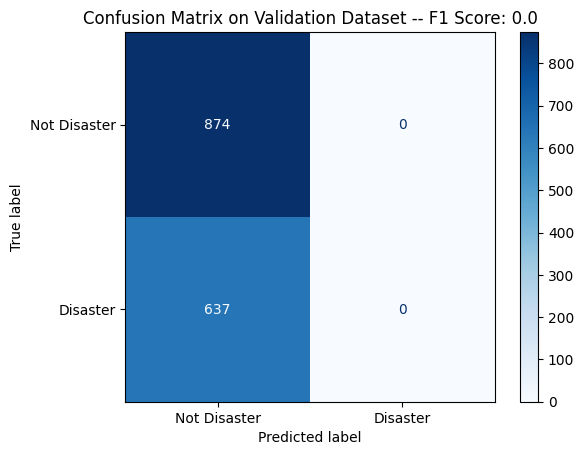

In [26]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate the submission file <a class="anchor"  id="h5"></a>